In [1]:
from iteru import *

In [2]:
from matplotlib import pyplot as plt

In [3]:
Map = Map()
Map

Map(center=[27, 31], controls=(SearchControl(found_style={'fillColor': '#3f0', 'color': '#0f0'}, marker=Marker…

In [66]:
Map.add_layer_widgets(SAR,{'min': [-49, -60, -10], 'max': [8, 5, 10], 'bands': ['VV', 'VH', 'VV/VH']},'SAR')

In [4]:
aoi = GERD_aoi

In [49]:
SAR = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.equals('relativeOrbitNumber_start', 50))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.eq('resolution_meters',10))\
    .filterBounds(aoi)\
    .filterDate('2022-04-30','2022-05-30')\
    .select(['VV','VH'])\
    .median()
  

In [63]:
SAR = SAR.addBands(band)

In [58]:
band = SAR.select('VV').divide(SAR.select('VH')).rename('VV/VH')

In [11]:
VV_smooth = SAR.select('VV').focal_median(50,'circle','meters').rename('VV_Filtered')

In [43]:
Map.add_layer_widgets(VV_smooth,{'min':-38.45,'max':5.07,'bands':['VV_Filtered']},'VV_Filtered')

In [13]:
SARF = ee.Image(toDB(RefinedLee(toNatural(SAR.select('VV')))))

In [14]:
Map.add_layer_widgets(SARF,{'min':-31,'max':5,'bands':['sum']},'SARF')

In [59]:
histogram = band.reduceRegion(
        reducer = ee.Reducer.histogram(255, 2).combine('mean', None, True).combine('variance', None, True),
        geometry = aoi,
        scale =10,
        bestEffort = True,
)

In [60]:
hist_dict = histogram.getInfo()

In [61]:
hist_dict

{'VV/VH_histogram': {'bucketMeans': [-223.22194549456685,
   -218,
   -214,
   -210,
   -206,
   -202,
   -198,
   -194,
   -190,
   -186,
   -182,
   -178,
   -174,
   -170,
   -167.01606862932846,
   -162,
   -158,
   -154,
   -150,
   -146,
   -142,
   -138,
   -134,
   -130,
   -126,
   -122,
   -118,
   -114,
   -110,
   -106,
   -102,
   -98,
   -94,
   -90,
   -86,
   -82,
   -78,
   -74,
   -70,
   -66,
   -62,
   -58,
   -54,
   -50,
   -46,
   -42,
   -38,
   -34,
   -29.656321520572696,
   -26,
   -22,
   -18.194815107213444,
   -13.373687193345955,
   -9.687803761898417,
   -5.373862198059649,
   -0.2421080187162011,
   0.6197055836005009,
   6.455612376512027,
   9.359660533138706,
   14,
   18.108230507781386,
   21.591114152396138,
   27.59591822914404,
   30,
   34,
   38,
   42,
   46,
   50,
   52.417119858298754,
   58.72904431443495,
   62,
   66,
   70,
   74.54570731613092,
   78,
   82,
   86,
   90,
   94,
   98,
   102,
   106,
   110,
   114,
   118,
   122,
 

In [17]:
x = hist_dict['sum_histogram']['bucketMeans']
y = hist_dict['sum_histogram']['histogram']

In [18]:
width = [2.3]*25

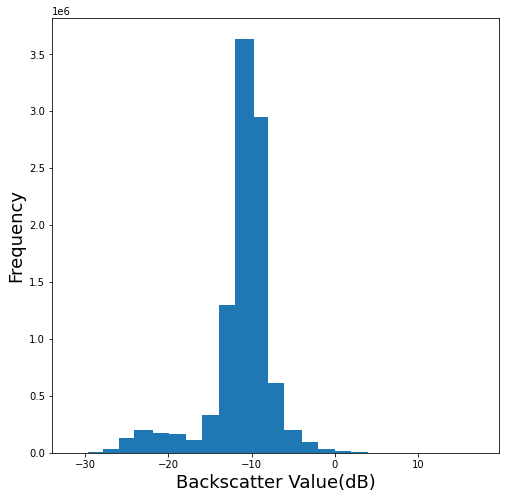

In [19]:
plt.bar(x,y, width = width)
plt.xlabel('Backscatter Value(dB)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.gcf().set_size_inches(8,8)

In [20]:
otsu_threshold = otsu(histogram.get('sum_histogram'))

In [21]:
water_mask = SARF.select('sum').lt(otsu_threshold.getInfo()).selfMask().rename('water_mask')

In [44]:
Map.add_layer_widgets(water_mask,{'palette': ['00FFFF', '0000FF'], 'bands':['water_mask']},'SARF')